In [1]:
import seaborn as sns
import pandas as pd
# sns.set(style="ticks")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = 14,12
matplotlib.rcParams['font.weight'] = "medium"

matplotlib.rcParams['axes.labelweight'] = 'medium'
matplotlib.rcParams['figure.titleweight'] = 'medium'
matplotlib.rcParams['axes.titleweight'] = 'medium'

sns.set(font_scale=1.1, style="ticks", font="Lato")

In [2]:
df = pd.read_csv('auc_delta_infos.tsv', sep='\t')
# print(df.head())
df = df[df.auc != 0]
# df_best = df[df.delta_type == 'best_in_family_delta']
df_best = df[df.delta_type == 'representative_delta:0']
sns.distplot(df_best['auc'])
# df_best.count()

{'Forkhead box (FOX) factors{3.3.1}', 'Ets-related factors{3.5.2}', 'Factors with multiple dispersed zinc fingers{2.3.4}', 'Three-zinc finger Krüppel-related factors{2.3.1}'}
{'all', 'best_in_family', 'representative:3', 'best_representative', 'proper_tf:MAZ', 'representative:6', 'representative:12', 'representative:1', 'representative:13', 'proper_tf:IKZF1', 'representative:5', 'best_overall', 'proper_tfs', 'representative:2', 'representative:8', 'representative:10', 'representative:7', 'proper_tf:BCL11A', 'representative:9', 'all_representatives', 'representative:0', 'representative:4', 'representative:14', 'representative:11'}


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


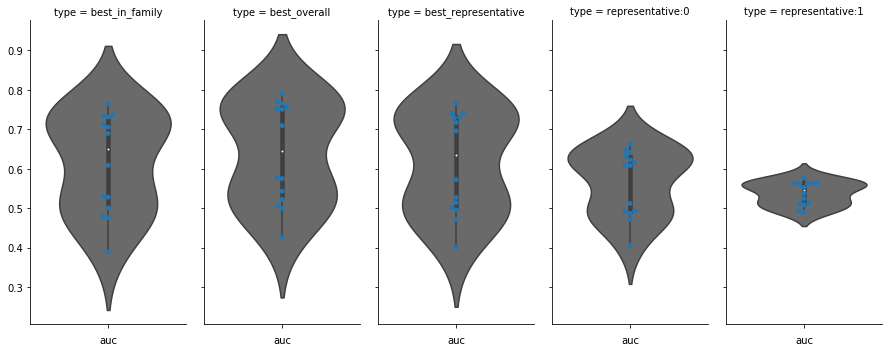

In [3]:
# sns.violinplot
df = pd.read_csv('auc_infos_by_family.tsv',sep='\t')
df.head()
print(set(df.family))
# df = df[df.family == 'Ets-related factors{3.5.2}']
# df = df[df.family == 'Three-zinc finger Krüppel-related factors{2.3.1}']
df = df[df.family == 'Factors with multiple dispersed zinc fingers{2.3.4}']
# df = df[df.family == 'Forkhead box (FOX) factors{3.3.1}']
print(set(df.type))
# sns.violinplot(df, orient='vertical',col='type')
# df = df[df.type.isin(['all', 'best_in_family', 'best_overall', 'representative:0', 'proper_tfs'])]
df = df[df.type.isin(['best_in_family', 'best_overall', 'best_representative', 'proper_tfs', 'representative:0', 'representative:1',])]
df = df[df.type.isin(['best_in_family', 'best_overall', 'best_representative', 'representative:0', 'representative:1',])]
g = sns.FacetGrid(df, col="type",height=5, aspect=0.5)
g.map(sns.violinplot, "auc", orient = 'v', saturation=0)
g.map(sns.swarmplot, "auc", orient = 'v')
# g.add_legend();

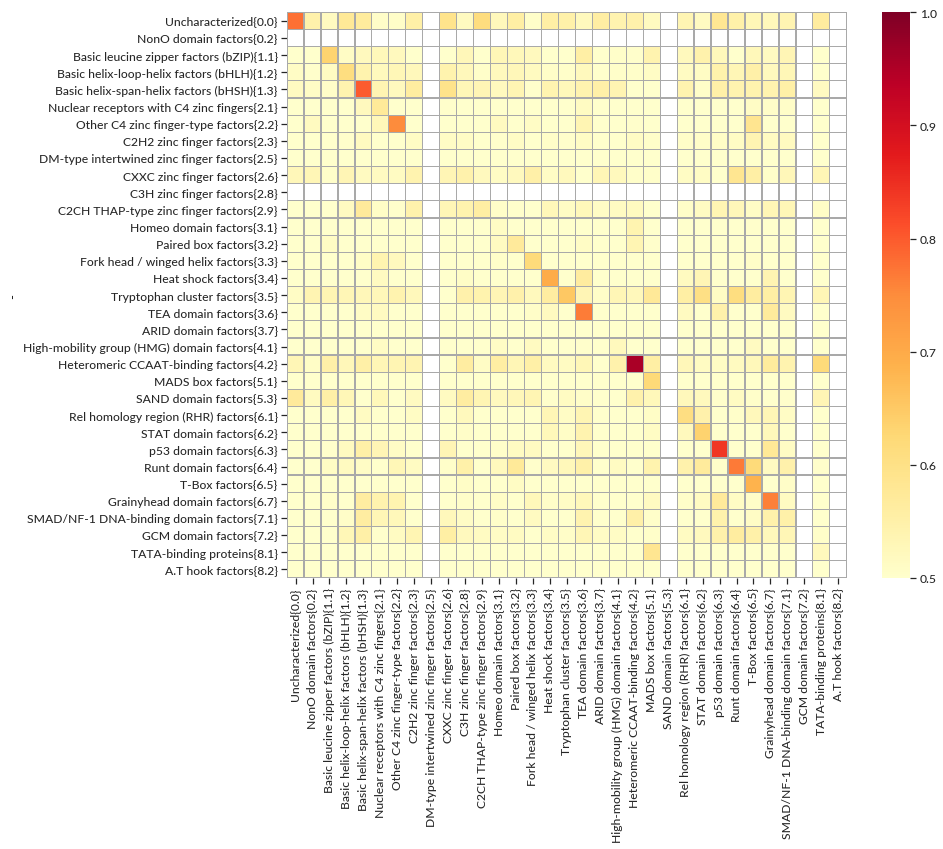

In [161]:
df = pd.read_csv('tf_families_heatmap.tsv', sep='\t',index_col=0)
g = sns.heatmap(df,vmin=0.5, vmax = 1, linewidths=.25, linecolor='darkgray',cmap='YlOrRd')
g = g.get_figure()
g.tight_layout()
g.savefig(f"heatmap_classes.svg", dpi=300)

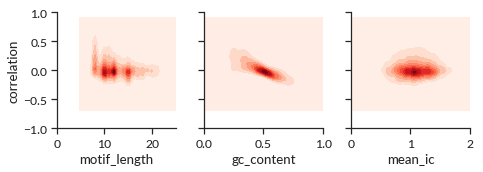

In [2]:
df = pd.read_csv('results/uniprobe/motif_tf_aucs.uniprobe.tsv', sep='\t')
df.columns = ['correlation', 'motif_length', 'gc_content', 'mean_ic']

g = sns.PairGrid(df, x_vars=['motif_length', 'gc_content', 'mean_ic'], y_vars=['correlation'], aspect=0.9)
for i in range(len(g.axes)):
    g.axes[0][i].set(ylim=(-1,1))
g.axes[0][0].set(xlim=(0,25))
g.axes[0][1].set(xlim=(0,1))
g.axes[0][2].set(xlim=(0,2))
g.map(sns.kdeplot, shade=True, cmap='Reds');
g.savefig(f"uniprobe_distplot.svg", dpi=300)

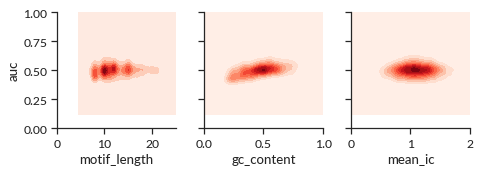

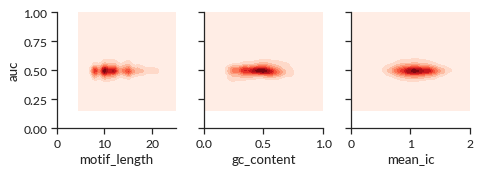

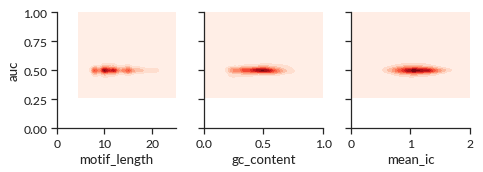

In [3]:
for dataset in ['remap', 'jy10', 'jy50']:
    df = pd.read_csv(f'results/{dataset}/motif_tf_aucs.{dataset}.tsv', sep='\t')
    g = sns.PairGrid(df, x_vars=['motif_length', 'gc_content', 'mean_ic'], y_vars=['auc'], aspect=0.9)
    for i in range(len(g.axes)):
        g.axes[0][i].set(ylim=(0,1))
    g.axes[0][0].set(xlim=(0,25))
    g.axes[0][1].set(xlim=(0,1))
    g.axes[0][2].set(xlim=(0,2))
    g.map(sns.kdeplot, shade=True, cmap='Reds');
    g.savefig(f"{dataset}_distplot.svg", dpi=300)

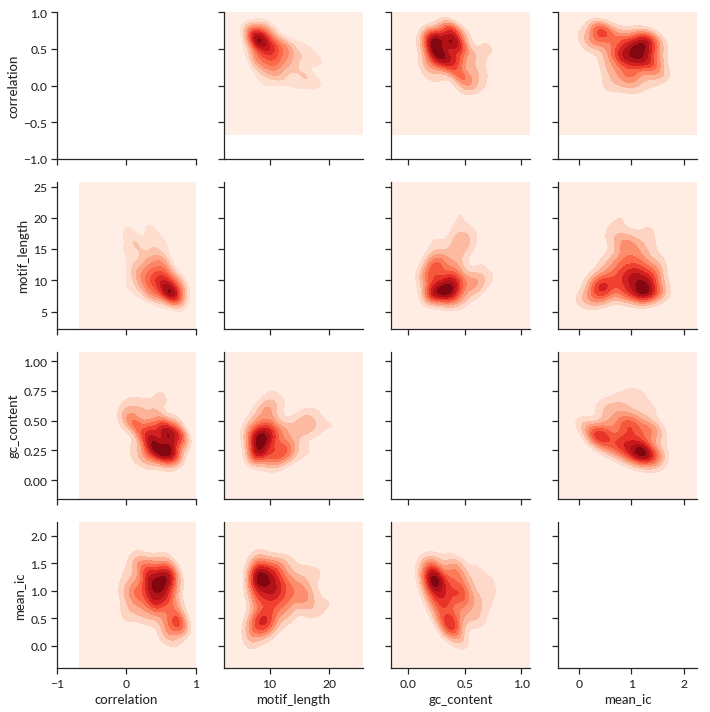

In [18]:
df = pd.read_csv('results/uniprobe/motif_tf_aucs.uniprobe.tsv', sep='\t')
df.columns = ['correlation', 'motif_length', 'gc_content', 'mean_ic']

g = sns.PairGrid(df)
# g.map_diag(sns.kdeplot)
for i in range(len(g.axes)):
    g.axes[0][i].set(ylim=(-1,1))
    g.axes[i][0].set(xlim=(-1,1))
g.map_offdiag(sns.kdeplot, shade=True, cmap='Reds');
g.savefig(f"uniprobe_distplot.svg", dpi=300)

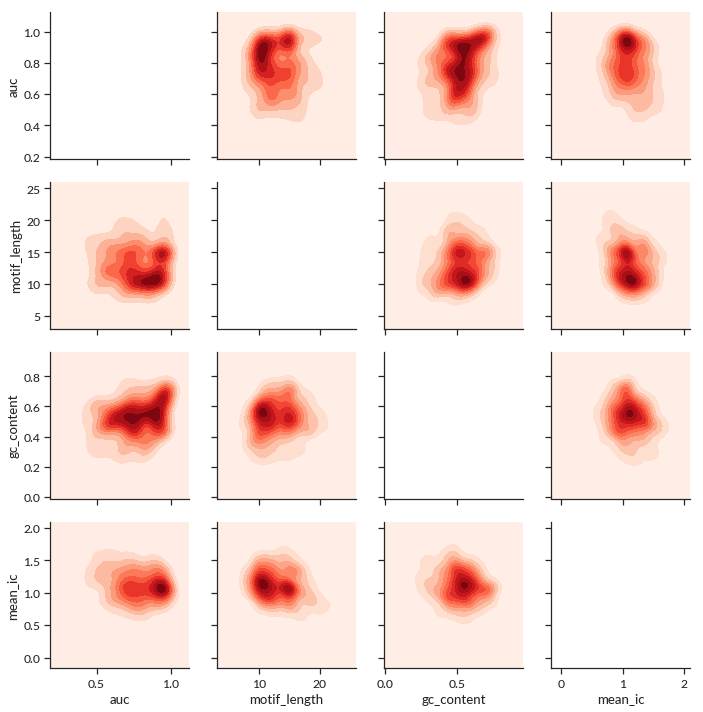

In [19]:
df = pd.read_csv('results/remap/motif_tf_aucs.remap.tsv', sep='\t')

g = sns.PairGrid(df)
# g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, shade=True, cmap='Reds');
g.savefig(f"remap_distplot.svg", dpi=300)

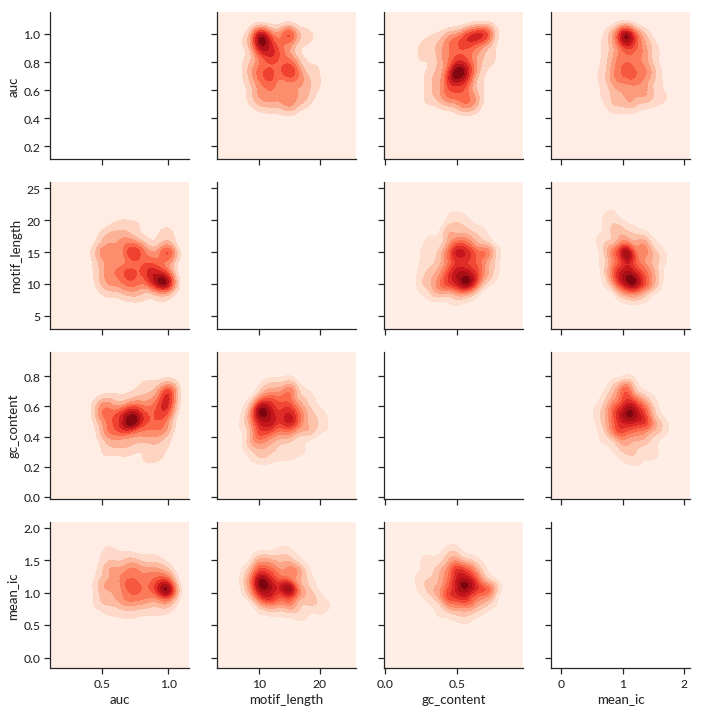

In [15]:
df = pd.read_csv('results/jy10/motif_tf_aucs.jy10.tsv', sep='\t')

g = sns.PairGrid(df)
# g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, shade=True, cmap='Reds');
g.savefig(f"jy10_distplot.svg", dpi=300)

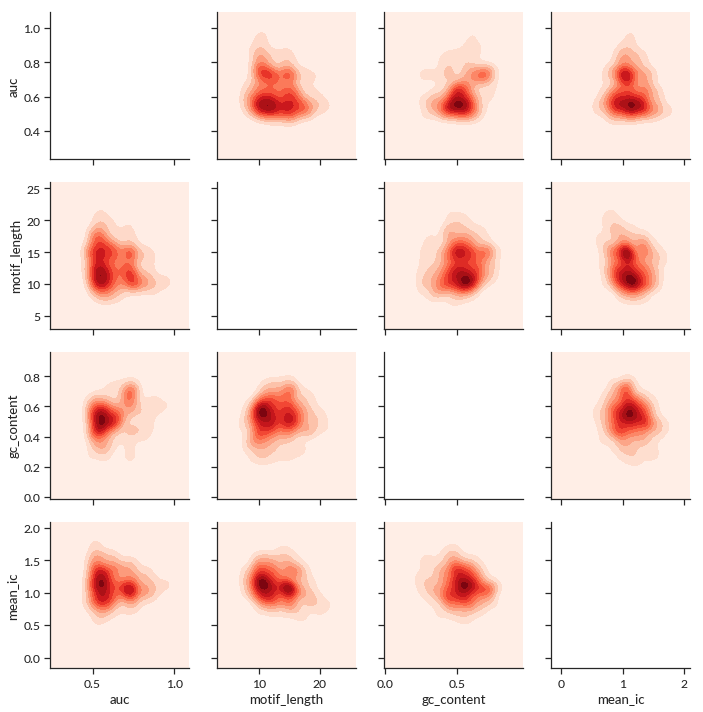

In [16]:
df = pd.read_csv('results/jy50/motif_tf_aucs.jy50.tsv', sep='\t')

g = sns.PairGrid(df)
# g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, shade=True, cmap='Reds');
g.savefig(f"jy50_distplot.svg", dpi=300)